## Milestone 2
Dataset: Open Food Facts

The dataset is downloaded and stored in the /data folder

In [2]:
%pprint
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
import folium
from geopy import distance
from geopy import Nominatim
from geopy.geocoders import *
from geopy.extra.rate_limiter import RateLimiter
sns.set()
sns.set(rc={'figure.figsize':(15,10)})

Pretty printing has been turned ON


In [3]:
data_folder = './data/'

# Data description

For our project, we are going to use several datasets:
- The [Open Food Facts](https://world.openfoodfacts.org/data) database
- The Gross Domestic Product (GDP) per country on [World Bank](https://data.worldbank.org/indicator/ny.gdp.mktp.cd)
- The Life Expectancy at birth per country on [World Bank](https://data.worldbank.org/indicator/SP.DYN.LE00.IN)

## Open Food Facts dataset

The data is in the CSV file format and can be downloaded on the Openfoodfacts website. Its size is 1.6 GB and we first decided for this milestone to download and load it using spark, as we were not sure if Pandas could handle a file of this size but as we quickly realized it was working smoothly so we will use Pandas to manipulate the data.

In [4]:
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', low_memory=False)
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that we have a lot of columns (173), not all of them will be useful for our project so we will select the most interesting ones and drop all the others to avoid keeping unused data for computations. We first chose to remove the columns related to subjects not related to our project for better readability like ingredients concentration per product, images, related to palm_oil...

In [5]:
not_related = ['100g', 'image', 'palm_oil', 'code', 'url']
columns = [column for column in list(data.columns) if not any(st in column for st in not_related)] 
columns

['creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'nutrition_grade_uk',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_en',
 'main_category',
 'main_category_en']

From the remainings columns we chose the ones that interests us the most. We made our choice first by judging the usefulness of each column in relation to our project and then by regarding in more details if the data in the column was usable.

In [6]:
keep = ['product_name','categories_tags','categories_en','origins_tags','manufacturing_places_tags','labels','countries_en','allergens','nutrition_grade_fr','main_category_en', 'pnns_groups_1', 'pnns_groups_2']
selected_data = data[keep]
selected_data.dtypes

product_name                 object
categories_tags              object
categories_en                object
origins_tags                 object
manufacturing_places_tags    object
labels                       object
countries_en                 object
allergens                    object
nutrition_grade_fr           object
main_category_en             object
pnns_groups_1                object
pnns_groups_2                object
dtype: object

The following columns are kept:

- product_name: name of the product
- categories_tags: categories of the product in 'tag' format
- categories_en: categories (in english)
- origins_tags: origins of ingredients in 'tag' format
- manufacturing_places_tags: place of manufacture of the product
- labels: label of the product(e.g. Bio..)
- countries_en: name of the countries in english where the product is sold
- allergens: allergens contained in the product
- nutrition_grade_fr: nutrition score given by Open Food Facts of the product
- main_category_en: main category of the product in english
- pnns_groups_1: category of te product according to the "Programme national nutrition santé" (pnns)
- pnns_groups_2: same

(tag format is the value in all lower caps, without accents and with - instead of spaces)

In [7]:
selected_data.dropna().head()

,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
1065,Cornish Cruncher Cheddar & Pickled Onion Hand ...,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",royaume-uni,royaume-uni,Point Vert,"France,United Kingdom","Lait, Lait, Babeurre",c,Plant-based foods and beverages,Salty snacks,Appetizers
1142,6 Breaded Jumbo Tiger Prawns,"en:meals,en:refrigerated-foods,en:breaded-prod...","Meals,Refrigerated foods,Breaded products,Refr...",vietnam,vietnam,"Point Vert,Décongelé","France,United Kingdom","Crevettes, Crustacés, blé, Gluten",c,Meals,Composite foods,One-dish meals
1347,"grilled Cajun chicken breast, spicy wedges & s...","en:meals,en:meat-based-products,en:meals-with-...","Meals,Meat-based products,Meals with meat,Poul...","europe,royaume-uni",royaume-uni,"Peu ou pas de matière grasse,Peu de matière gr...","France,United Kingdom",Lait,a,Meals,Composite foods,One-dish meals
1354,Cornish Cove Cheddar,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,royaume-uni,Point Vert,France,Lait,d,Dairies,Milk and dairy products,Cheese
1392,Mild Cheddar with Onions & Chives,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,"royaume-uni,irelande",Point Vert,"France,United Kingdom","Fromage, Lait",d,Dairies,Milk and dairy products,Cheese


We save this dataframe in a csv file to speed up the loading process in our next runs.

In [8]:
selected_data.to_csv(data_folder + 'selected_data.csv')

Since there seems to be a lot of null values in the dataset, it can be interesting to take a look at the number of values that we have per remaining selected column.

In [9]:
selected_data.count()

product_name                 671470
categories_tags              179971
categories_en                179937
origins_tags                  42429
manufacturing_places_tags     67336
labels                       102161
countries_en                 696976
allergens                     69069
nutrition_grade_fr           141083
main_category_en             179860
pnns_groups_1                257347
pnns_groups_2                263288
dtype: int64

We can also represent the filling of the columns as percentages to better visualize it :

In [10]:
selected_data.count() / max(selected_data.count()) * 100

product_name                  96.340477
categories_tags               25.821693
categories_en                 25.816814
origins_tags                   6.087584
manufacturing_places_tags      9.661165
labels                        14.657750
countries_en                 100.000000
allergens                      9.909810
nutrition_grade_fr            20.242160
main_category_en              25.805767
pnns_groups_1                 36.923366
pnns_groups_2                 37.775763
dtype: float64

For this dataset, the most important tags are the followings:`countries_en`, `origin`, `manufacturing_places` and `nutrition_grade_fr`

### `countries_en`

This column contains the names of the countries where the product is sold, separated by a comma. Without cleaning (this will be later on), the distribution of the values are as follows: 

In [33]:
def print_dis(column, output_name):
    counts = column.value_counts()
    counts = counts[:30,]
    plot = sns.barplot(y=counts.index, x=counts.values, alpha=0.8)
    plot.get_figure().savefig(output_name)

In [34]:
selected_data.countries_en.unique()[:50]

array(['France', 'United States', 'Ireland', 'United Kingdom',
       'France,United States', 'Canada', 'Switzerland', 'Peru', 'Oman',
       'Spain', 'Germany', 'Slovenia', 'Qatar', 'France,Germany', 'Italy',
       'Romania', 'Australia', 'Portugal', 'Israel',
       'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe',
       'Belgium', 'Mexico', 'United Kingdom,United States',
       'Dominican Republic', 'Canada,United States', 'Netherlands',
       'Australia,France', 'Sweden', 'Canada,Switzerland,United States',
       'Luxembourg', 'Egypt', 'Canada,France', 'Palestinian territories',
       'Haiti', 'Mexico,United States', nan, 'France,Réunion', 'Taiwan',
       'Australia,Belgium,France,Switzerland', 'Brazil', 'France,Spain',
       'Belgium,France', 'France,En', 'France,Switzerland', 'Guatemala',
       'Australia,France,New Zealand', 'Australia,United States',
       'Saudi Arabia'], dtype=object)

The values are pretty clean, with a few exceptions (fr:XX..) that we decided to drop later. As for the distribution, for now, it looks as follows:

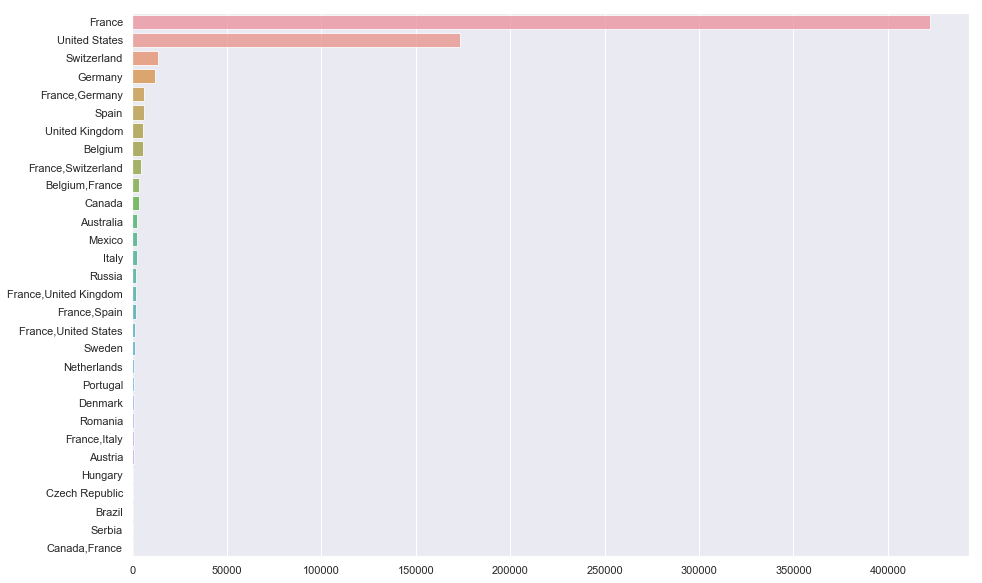

In [35]:
print_dis(selected_data.countries_en, data_folder + 'hist_countries.png')

Here, we are facing our first problem, while the countries have more than enough samples in it (we still need to check the distribution later on), the `origins` and `manufacturing_places` both represent less than 10% of the data. Now, if we check at the actual values of them:

### `manufacturing_places_tags`

In [14]:
selected_data.manufacturing_places_tags.unique()[:50]

array([nan, 'france', 'brossard-quebec', 'united-kingdom',
       'brossard,quebec', 'etats-unis', 'france,avranches',
       'brossars,quebec', 'thailand', 'belgien', 'net-wt',
       'las-ventas-de-retamosa,toledo-provincia,castilla-la-mancha,espana',
       'saint-yrieix,france', 'germany',
       'france,limousin,87500,saint-yrieux', 'france,87500',
       '87500,france', 'sarlat', 'pays-bas,netherlands', 'royaume-uni',
       'royaume-uni,ecosse', 'belgique', 'ireland', '87500-saint-yrieix',
       'ecosse,royaume-uni', 'black-sheep-brewery',
       'estados-unidos-americanos', 'vietnam', 'argentine', 'usa',
       '30800-st-gilles', 'chester,united-kingdom', 'uk',
       'royaume-uni,irelande', 'california,usa', 'italie', 'china',
       'angleterre', 'switzerland', 'canada', 'mexico',
       'the-hershey-company', 'cincinnati', 'united-states', 'taiwan',
       'japon', 'japan', 'topco', 'san-nicolas-de-los-garza,nuevo-leon',
       'san-francisco-california'], dtype=object)

As we can see, the values are a bit messy and not uniform at all. Now if we look at the counts of value and its distribution:

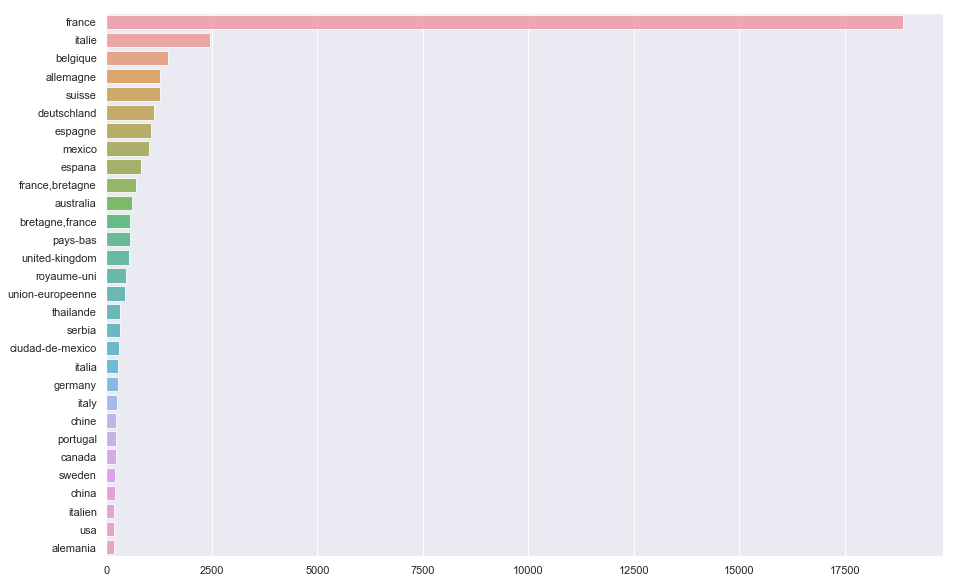

In [36]:
print_dis(selected_data.manufacturing_places_tags, data_folder + 'hist_manu.png')

First of all, some values requires some cleaning, but we can still see the main problem: the values are dominated by the value "France", which makes our data very biased.

### `origins_tags`

Let's do the same for the origins:

In [16]:
selected_data.origins_tags.unique()[:50]

array([nan, 'france', 'quebec', 'quebec,canada', 'united-kingdom',
       'germany', 'ue', 'canada', 'grande-bretagne',
       'estados-unidos-americanos', 'royaume-uni', 'vietnam', 'argentine',
       'brazil', 'england', 'europe,royaume-uni',
       'easter-grangemuir-farm,pittenweem,fife,ky10-2rb,scotland,united-kingdom',
       'royaume-uni,hors-royaume-uni', 'perou', 'italie', 'tibet',
       'espagne,royaume-uni', 'united-states', 'madagascar', 'mexico',
       'taiwan', 'japon', 'usa', 'estados-unidos', 'california', 'estero',
       'atlantique-nord-ouest,canada', 'suisse', 'saudi',
       'estados-unidos-de-america', 'britain,british-chicken', 'italy',
       'francia', 'fougerolles,france', 'ancaster,ontario,canada',
       'scotland', 'royaume-uni,west-sussex', 'malaisie',
       'washington,usa', 'e-u-a', 'etats-unis', 'californie,etats-unis',
       'new-zealand', 'sicile,italie', 'indetermine'], dtype=object)

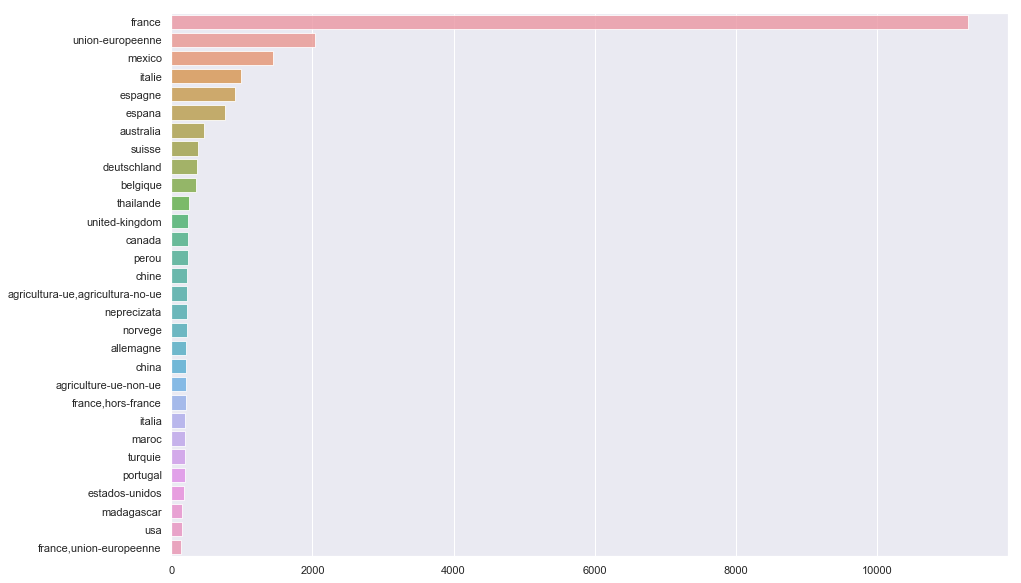

In [37]:
print_dis(selected_data.origins_tags, data_folder + 'hist_origins.png')

We encounter here the same problem. Our origins and manufacturing places are heavily biased because of an overwhelming number of food originating from France.

In [18]:
a = selected_data['origins_tags'].dropna(how='all').str.lower()
a[a.str.contains('suisse')].count()

571

In [19]:
a = selected_data['origins_tags'].dropna(how='all').str.lower()
a[a.str.contains('france')].count()

16583

We are now facing another problem, all the tags are not normalized and a lot of them are even invalid ("mer", postal code, or in other languages). 

### `nutrition_score_fr`

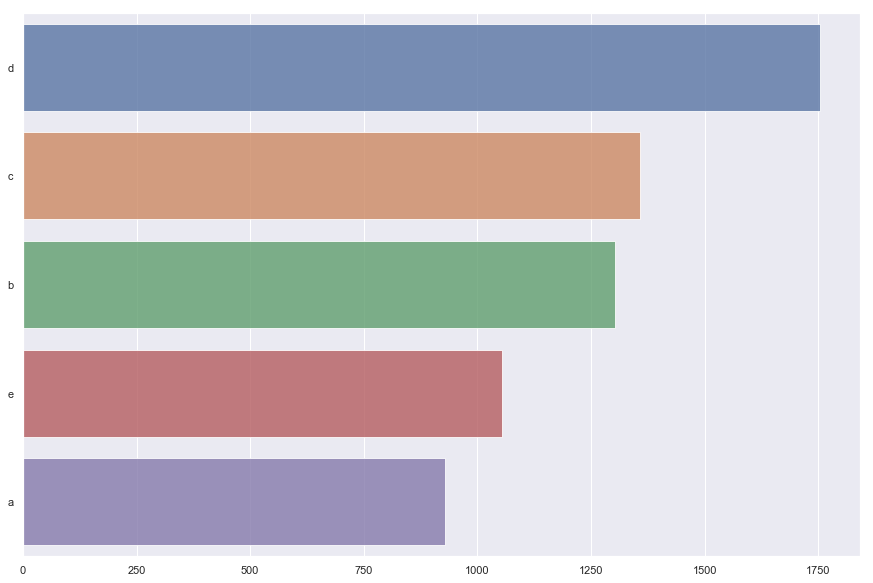

In [20]:
print_dis(selected_data.dropna().nutrition_grade_fr, 'hist_nutri_score.png')

We replace the letters used to grade the nutrition score by integers to be able to quantify the mean average score. The higher the note, the better the nutrition score is.

In [48]:
mapping_nutrition = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1, 'f': 0}
mapped = selected_data.dropna().replace({'nutrition_grade_fr': mapping_nutrition})
mapped.head()

,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
1065,Cornish Cruncher Cheddar & Pickled Onion Hand ...,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",royaume-uni,royaume-uni,Point Vert,"France,United Kingdom","Lait, Lait, Babeurre",3,Plant-based foods and beverages,Salty snacks,Appetizers
1142,6 Breaded Jumbo Tiger Prawns,"en:meals,en:refrigerated-foods,en:breaded-prod...","Meals,Refrigerated foods,Breaded products,Refr...",vietnam,vietnam,"Point Vert,Décongelé","France,United Kingdom","Crevettes, Crustacés, blé, Gluten",3,Meals,Composite foods,One-dish meals
1347,"grilled Cajun chicken breast, spicy wedges & s...","en:meals,en:meat-based-products,en:meals-with-...","Meals,Meat-based products,Meals with meat,Poul...","europe,royaume-uni",royaume-uni,"Peu ou pas de matière grasse,Peu de matière gr...","France,United Kingdom",Lait,5,Meals,Composite foods,One-dish meals
1354,Cornish Cove Cheddar,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,royaume-uni,Point Vert,France,Lait,2,Dairies,Milk and dairy products,Cheese
1392,Mild Cheddar with Onions & Chives,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,"royaume-uni,irelande",Point Vert,"France,United Kingdom","Fromage, Lait",2,Dairies,Milk and dairy products,Cheese


## Gross Domestic Product and Life Expectancy dataset

In [7]:
gdp = pd.read_csv(data_folder + 'GDP.csv')

In [8]:
gdp = gdp[['Country Name', 'Country Code', '2017']].dropna()
gdp.columns = ['countries_en', 'country_code', '2017']
gdp.to_pickle(data_folder + 'gdp.pkl')
gdp.head()

,countries_en,country_code,2017
1,Afghanistan,AFG,2.081530e+10
2,Angola,AGO,1.242094e+11
3,Albania,ALB,1.303935e+10
4,Andorra,AND,3.012914e+09
5,Arab World,ARB,2.591047e+12


We kept the following columns:
- countries_en: name of the countries in english
- country_code: country codes
- 2017: 2017 GDP values (most recent available)

We plot the distribution:

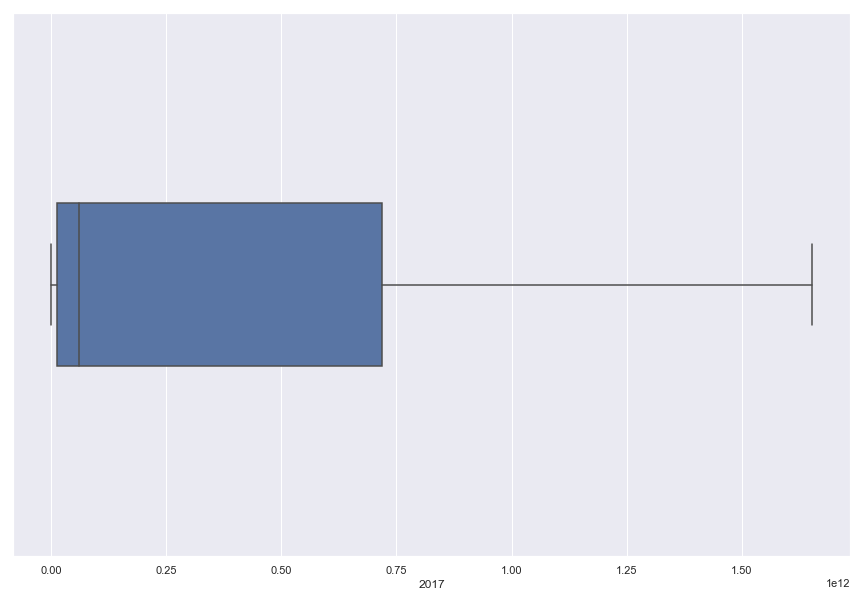

In [51]:
sns.boxplot(x=(gdp['2017']), showfliers=False, width=0.3)

There are some extreme offliers that crush the boxplots, and we see the the first 50 percentile is very condensed. The statistical description of the values is the following :

In [24]:
gdp['2017'].describe()

count    2.340000e+02
mean     2.848129e+12
std      9.177562e+12
min      3.973132e+07
25%      1.150900e+10
50%      5.944777e+10
75%      7.175373e+11
max      8.068379e+13
Name: 2017, dtype: float64

We also want to observe an eventual relation between food quality and health. For this we also found on the same website the LE.csv file from which we can obtain the life expectancy per country. We will use the data for year 2016 as it is the most recent available year (year 2017 has no value) :

In [24]:
le = pd.read_csv(data_folder + 'LE.csv')
#le.head()

In [25]:
le = le[['Country Name', 'Country Code', '2016']].dropna()
le.columns = ['countries_en', 'country_code', '2016']
le.to_pickle(data_folder + 'le.pkl')
le.head()

,countries_en,country_code,2016
0,Aruba,ABW,75.867000
1,Afghanistan,AFG,63.673000
2,Angola,AGO,61.547000
3,Albania,ALB,78.345000
5,Arab World,ARB,71.198456


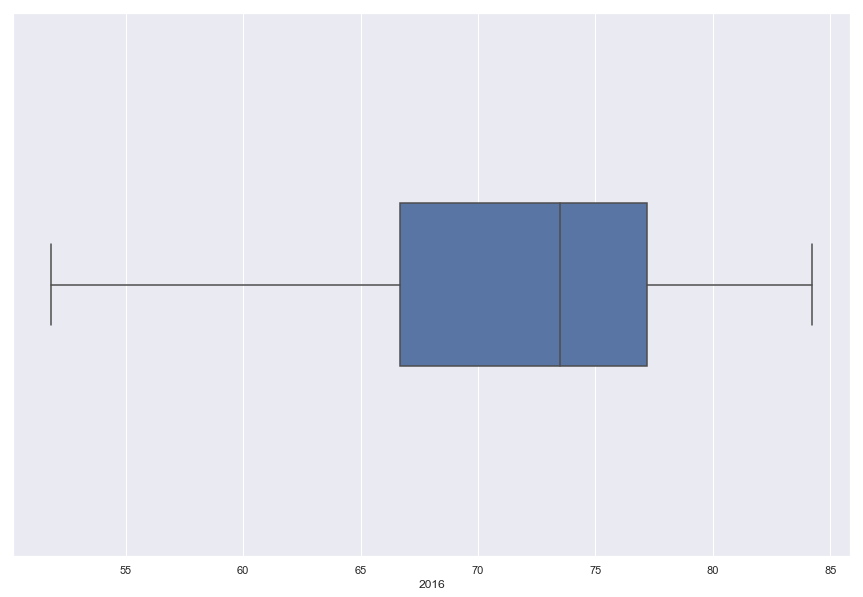

In [42]:
sns.boxplot(x=(le['2016']), showfliers=False, width=0.3)

Here we see that the life expectancy seems to be more uniformly distributed that our results for the GDP. We observe that we have also very distant low outliers, and also high outliers, that extends the boxplot.

In [43]:
le['2016'].describe()

count    245.000000
mean      71.992486
std        7.515606
min       51.835000
25%       66.683000
50%       73.473000
75%       77.203000
max       84.226829
Name: 2016, dtype: float64

In [29]:
result = gdp.join(le, lsuffix='_caller', rsuffix='_other')

In [30]:
result['2017'].corr(result['2016'])

0.16017123003591782

As it is shown the level of correlation between both values, the ones from the GDP and the ones from the Life Expectancy are not veryy correlated. We will try to compute the one between the average nutritient scores and both the life expectancy and GDP and see if we manage to observe more interesting results.

For convenience, we will here create a dataframe containing the countries names and the country code from this dataset:

In [26]:
country_code = le[['countries_en', 'country_code']]
country_code.to_pickle(data_folder + 'country_code.pkl')

# Geopy

In order to compute the impact of the globalization we desire to compute the distance between countries. For that we decided to use GeoPy. A dataset that holds the localization of the cities and countries around the world.

In [48]:
#Computes distance between two points
d = distance.distance
#Allows looking for a location
g = Nominatim(user_agent="app_name")
#Finds the geographic center of a country or city as specified
_, fr = g.geocode('france')
_, uk = g.geocode('united-kingdom')
print(fr)
print(uk)
print(d(fr, uk))

(46.603354, 1.8883335)
(54.7023545, -3.2765753)
971.5166387817475 km


To measure distances between countries we can either decide to use the capitals per country as their point of reference or we can use the name of the country e.g. France to get the center of the country as a point of reference.

By using the values found in the columns of origins and countries we can directly compute the distance in kilometers between countries. We decided that to keep fairness, we will measure the distances between the centers of the countries. 

To compute its impact in the environment we should use the carbon footprint. However, this data is inconsistent and very small inside our dataset. So, as a general carbon footprint we will compute the average of the ones we have in the dataset to use it as a unit per kilometer for each product.

In [33]:
avg_footprint = data['carbon-footprint_100g'].sum()/data['carbon-footprint_100g'].count()
avg_footprint

269.9532424970931

# Cleaning the data

In this part, we will take care of the missing values as well as properly formating the columns.

## Open Food Facts dataset

In [18]:
data_selected = pd.read_csv(data_folder + 'selected_data.csv')
data_selected.head()

,Unnamed: 0,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
0,0,Vitória crackers,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
1,1,Cacao,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
2,2,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
3,3,Mini coco,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
4,4,Mendiants,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN


## Countries

We saw before that countries are often written as list of countries in the dataset columns, we need to expand these lists to be able to use this data (acts like split() + explode()) : 

In [19]:
#Splits the rows in different rows for each of the values in a list of the specified column
def first_spliter(df, col):
    s = df[col].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[col] = s.values
    return df2

#Splits the rows in different rows for each of the values in a list of the specified column
def splitter(df, col):
    return df.drop(col, axis=1).join(df[col].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename(col))


Drop the unwanted rows

In [20]:
data_countries = data_selected[data_selected['countries_en']!=""]
data_origins = data_countries[data_countries['origins_tags']!=""]
data_manu = data_countries[data_countries['manufacturing_places_tags']!=""]

In [21]:
data_countries15 = splitter(data_countries, 'countries_en')

In [27]:
data_countries_cleaned = data_countries15.merge(country_code, how='inner')

In [52]:
data_countries_cleaned.count()

Unnamed: 0                   722887
product_name                 697492
categories_tags              194010
categories_en                194010
origins_tags                  45427
manufacturing_places_tags     74092
labels                       110499
allergens                     75430
nutrition_grade_fr           154605
main_category_en             193963
pnns_groups_1                273865
pnns_groups_2                280197
countries_en                 722887
country_code                 722887
dtype: int64

In [56]:
mapped_by_countries = mapped[mapped['countries_en']!=""]
mapped_by_countries = splitter(mapped_by_countries, 'countries_en')
mapped_by_countries.to_pickle('mapped_by_countries.pkl')

## Origins and Manufacturing places

In order to clean the data of the `origins` and `manufacturing_places` columns, we are going to use GeoPy.

In [25]:
origins_df = pd.DataFrame(data_origins.origins_tags.unique())

origins_df.columns = ['origins_tags']

splitted = splitter(origins_df, 'origins_tags')

splitted['freq'] = splitted.groupby('origins_tags')['origins_tags'].transform('count')

Here, we drop all origins that appears less than 10 times, because they are more likely to be unvalid values. Theses values also doesn't provide a lot of information.

In [26]:
unique_split = splitted.sort_values(by='freq').drop_duplicates()

unique_split = unique_split[unique_split.freq > 3]

for index, row in unique_split.iterrows():
    print(row['origins_tags'])

fao61
norwegische-see
aude
catalogne
andalousie
viande-origine-france
moselle
bassin-de-l-adour
ivory-coast
pyrenees
indonesia
beurre-aop-charentes-poitou
bolivia
fao-81
parma
agypten
japan
senonches
seine-et-marne
poulet
canard
russia
centre-val-de-loire
argentinien
revel
grand-est
le-porc-francais
ble-france
autre
filipinas
colombia
ain
gatinais
beringsee
crete
lettre-h
dauphine
lettre-i
alpes-de-haute-provence
norwegen
maine-et-loire
ble-de-france
eu-landwirtschaft
aqualande
valencia
correze
cambodge
soja-bio
pommes-de-terre
cee
ouest-de-la-france
bolivien
melange
saint-galmier
origine-france
californie
pacifique-centre-est
nordsee
murcia-comunidad-autonoma
madrid-comunidad-autonoma
pate-de-cacao
ouest-ecosse
pacifique-centre-ouest
acores
bulgaria
hors-communaute-europeenne
fao-27-vii
toscane
atlantique-sud-est
mer-d-irlande
south-australia
guyane
grand-ouest
tunisia
creme
pomme-origine-france
marne
amazonie
haute-provence
saumon
la-rioja
modene
douarnenez
turquia
volaille-origine-f

Based on this, we can use geopy on the remaining values to get the locations

In [27]:
geocode = RateLimiter(g.geocode, min_delay_seconds=1)
unique_split['location'] = unique_split['origins_tags'].apply(geocode)

In [28]:
unique_split = unique_split.dropna()

In [29]:
unique_split.to_pickle(data_folder + 'origins_positions.pkl')

In [11]:
unique_split = np.load(data_folder + 'origins_positions.pkl', allow_pickle=True)

In [12]:
unique_split

,origins_tags,freq,location
4222,aude,4.0,"(Aude, Occitanie, France métropolitaine, Franc..."
6363,catalogne,4.0,"(CAT, España, (41.8523094, 1.5745043))"
6345,andalousie,4.0,"(Andalucía, España, (37.3399964, -4.5811614))"
1303,moselle,4.0,"(Moselle, Grand Est, France métropolitaine, Fr..."
5303,ivory-coast,4.0,"(Côte d’Ivoire, (7.9897371, -5.5679458))"
299,pyrenees,4.0,"(Pyrénées, Oô, Saint-Gaudens, Haute-Garonne, O..."
517,indonesia,4.0,"(Indonesia, (-4.7993356, 114.5632032))"
5036,bolivia,4.0,"(Bolivia, (-17.0568696, -64.9912286))"
1066,fao-81,4.0,"(Fao, Cercle de Youwarou, Mopti, Mali, (15.511..."
6070,parma,4.0,"(Parma, PR, EMR, Italia, (44.8013678, 10.32808..."


We do the same for `manufacturing_places`

In [32]:
manu_df = pd.DataFrame(data_manu.manufacturing_places_tags.unique())

manu_df.columns = ['manufacturing_places']

splitted_manu = splitter(manu_df, 'manufacturing_places')

splitted_manu['freq'] = splitted_manu.groupby('manufacturing_places')['manufacturing_places'].transform('count')

unique_split_manu = splitted_manu.sort_values(by='freq').drop_duplicates()

unique_split_manu = unique_split_manu[unique_split_manu.freq > 3]

for index, row in unique_split_manu.iterrows():
    print(row['manufacturing_places'])

agis-filiale-groupe-lambert-dodard-chancereul-ldc-za-du-clos-du-poivre-route-d-asserac-44410-herbignac
архангельская-область
pays-de-loire
picanya
85600-bouffere
saint-agreve
landerneau
valladolid
14670
mechelen
senagral-filiale-senoble-avenue-des-saulniers-zone-industrielle-57170-chateau-salins
brest
binic
andalousie
tailandia
toscane
sable-sur-sarthe
35230-bourgbarre
eyguebelle
lfo-sas
lons
maia
35230
romans
ceyzeriat
saint-thurien
leppersdorf
jus-de-fruits-d-alsace-jfa-filiale-laiterie-de-saint-denis-de-l-hotel-lsdh-zone-industrielle-rimsdorf-67260-sarre-union
орловская-область
irlande-du-nord
vitry-sur-seine
biscuits-bouvard
aquitaine-limousin-poitou-charentes
santa-cruz-de-tenerife-provincia
halle
languedoc-roussillon-midi-pyrenees
guadalajara
fabrique-en-france
monteux
granada
tulette
metropole-de-lyon
frankfurt-am-main
compagnie-generale-de-conserve-cgc-filiale-groupe-cecab-za-saint-leonard-nord-kerlurec-56450-theix
puzol
bree
fromagerie-mulin-filiale-sodagral-lieu-dit-champs-br

In [ ]:
g = Nominatim(user_agent="app_name")
geocode = RateLimiter(g.geocode, min_delay_seconds=1)
unique_split_manu['location_manu'] = unique_split_manu['manufacturing_places'].apply(geocode)

In [37]:
unique_split_manu = unique_split_manu.dropna()
unique_split_manu.to_pickle(data_folder + 'manu_positions.pkl')

In [13]:
unique_split_manu = np.load(data_folder + 'manu_positions.pkl', allow_pickle=True)

In [14]:
unique_split_manu

,manufacturing_places,freq,location_manu
9004,архангельская-область,4.0,"(Архангельская область, Северо-Западный федера..."
3745,pays-de-loire,4.0,"(Pays de la Loire, France métropolitaine, Fran..."
11524,picanya,4.0,"(Picanya, l'Horta Oest, València / Valencia, C..."
3784,85600-bouffere,4.0,"(Boufféré, La Roche-sur-Yon, Vendée, Pays de l..."
5904,saint-agreve,4.0,"(Saint-Agrève, Tournon-sur-Rhône, Ardèche, Auv..."
6059,landerneau,4.0,"(Landerneau, Brest, Finistère, Bretagne, Franc..."
2084,valladolid,4.0,"(Valladolid, Castilla y León, España, (41.6521..."
5390,14670,4.0,"(Saint-Pierre-du-Jonquet, Normandie, France mé..."
9378,mechelen,4.0,"(Mechelen, Antwerpen, Vlaanderen, België / Bel..."
6065,brest,4.0,"(Brest, Finistère, Bretagne, France métropolit..."


With this, we should be able to compute the final dataframe we need for each of our research questions:

In [15]:
unique_split_manu = unique_split_manu.drop('freq', axis=1)
unique_split = unique_split.drop('freq', axis=1)

In [28]:
data_for_manu = data_countries_cleaned[data_countries_cleaned['manufacturing_places_tags']!=""]

In [29]:
data_for_manu = splitter(data_for_manu, 'manufacturing_places_tags')

In [30]:
data_for_manu = data_for_manu.merge(unique_split_manu, left_on='manufacturing_places_tags', right_on='manufacturing_places', how='inner')

In [31]:
data_for_manu.drop(['manufacturing_places_tags', 'manufacturing_places'], axis=1).to_pickle('data_for_manu.pk1')

In [32]:
data_for_origins = data_countries_cleaned[data_countries_cleaned['origins_tags']!=""]
data_for_origins = splitter(data_for_origins, 'origins_tags')
data_for_origins = data_for_origins.merge(unique_split, how='inner')

In [33]:
data_for_manu.drop('origins_tags', axis=1).to_pickle(data_folder + 'data_for_origins.pkl')

In [36]:
data_for_manu.to_pickle(data_folder + 'data_for_manu.pkl')
data_for_origins.to_pickle(data_folder + 'data_for_origins.pkl')

In [4]:
data_for_manu = np.load(data_folder + 'data_for_manu.pkl', allow_pickle=True)
data_for_origins = np.load(data_folder + 'data_for_origins.pkl', allow_pickle=True)
data_countries_cleaned = np.load(data_folder + 'data_countries_cleaned.pkl', allow_pickle=True)
country_code = np.load(data_folder + 'country_code.pkl', allow_pickle=True)
mapped_by_countries = np.load(data_folder + 'mapped_by_countries.pkl', allow_pickle=True)
le = np.load(data_folder + 'le.pkl', allow_pickle=True)
gdp = np.load(data_folder + 'gdp.pkl', allow_pickle=True)

## More data cleaning

In [5]:
data_for_manu['lat'] = data_for_manu['location_manu'].apply(lambda x: x.latitude)
data_for_manu['lon'] = data_for_manu['location_manu'].apply(lambda x: x.longitude)
data_for_manu['coords'] = list(zip(data_for_manu.lat, data_for_manu.lon))

In [35]:
data_unique = pd.DataFrame(data_for_manu['coords'].unique())

In [37]:
g = Nominatim(user_agent="app_name")
geocode = RateLimiter(g.reverse, min_delay_seconds=1)
def helper_convert(coords):
    address,_ = geocode(coords, language='en')
    if address:
        address = address.split(",")
        return address[-1]
    else: 
        return ""

In [47]:
data_unique['country_name'] = data_unique[0].apply(helper_convert)

In [50]:
data_unique.columns = ['manu_coords', 'manu_country']

In [53]:
data_unique.to_pickle(data_folder + 'manu_coords.pkl')

In [56]:
data_for_origins['lat'] = data_for_origins['location'].apply(lambda x: x.latitude)
data_for_origins['lon'] = data_for_origins['location'].apply(lambda x: x.longitude)
data_for_origins['coords'] = list(zip(data_for_origins.lat, data_for_origins.lon))
data_unique_origins = pd.DataFrame(data_for_origins['coords'].unique())
data_unique_origins['country_name'] = data_unique_origins[0].apply(helper_convert)

In [58]:
data_unique_origins.to_pickle(data_folder + 'origins_coords.pkl')

With this, we now can compute the country for the manufacturing place and origins

In [94]:
data_unique_origins = np.load(data_folder + 'origins_coords.pkl', allow_pickle=True)
data_unique_manu = np.load(data_folder + 'manu_coords.pkl', allow_pickle=True)

In [70]:
data_unique_origins['country_name'].unique()

array([' France', ' Italy', ' United Kingdom', ' Vietnam', ' Argentina',
       ' Europe', ' Peru', ' Spain', ' Madagascar', ' USA', ' Senegal',
       ' Canada', ' Malaysia', ' Thailand', ' Chile', ' Costa Rica',
       ' Territorial waters of Greece - Gavdos and Gavdopoula',
       ' Netherlands', ' Kenya', ' RSA', ' PRC', ' Brazil', ' Africa',
       ' Switzerland', 'Philippines', ' New Zealand', ' Guatemala',
       ' D.R.', ' Turkey', ' Sri Lanka', ' Poland', ' India',
       ' Indonesia', ' Israel', ' Hungary', ' Asia', '', ' Colombia',
       ' Burkina Faso', ' Nicaragua', ' Ecuador', ' Tunisia',
       'Atlantic Ocean', ' El Salvador', ' Norway', ' 8064', ' Iceland',
       ' Territorial waters of Faroe Islands', ' Russia', ' Ghana',
       ' Bulgaria', ' Ethiopia', ' Japan', ' Liberia', 'Pacific Ocean',
       ' Mali', ' Australia', ' Bolivia', ' Paraguay', ' Belgium',
       ' Uganda', ' Haiti', ' Mexico', ' Pakistan', 'Indian Ocean',
       ' ROC', ' Morocco', ' Sweden', ' G

In [65]:
data_unique_manu['manu_country'].unique()

array([' France', ' USA', ' Netherlands', ' United Kingdom', ' Belgium',
       ' Vietnam', ' Argentina', ' Italy', ' Switzerland', ' Japan',
       ' Indonesia', ' Spain', ' Luxembourg', ' Europe', ' Mexico',
       ' Thailand', ' Israel', ' ROC', ' PRC', ' Austria', ' Greece',
       ' Peru', 'Denmark', 'Philippines', ' Canada', ' Croatia',
       ' Ireland', ' RSA', ' Poland', ' Portugal', ' Australia',
       ' Hungary', ' South Korea',
       ' Polynésie française (eaux territoriales)', '', ' Bulgaria',
       ' Territorial waters of Greece - Gavdos and Gavdopoula', ' Haiti',
       ' Turkey', ' India', ' Germany', ' Sri Lanka', ' Morocco',
       ' Cameroon', ' Ecuador', ' Tunisia', ' Brazil', ' Sweden',
       ' Estonia', ' Finland', ' Egypt', ' Seychelles', ' Czechia',
       ' Chile', ' Ukraine', ' Venezuela', ' Philippines', ' Jersey',
       ' Algeria', ' Russia', ' Africa', ' Guyana', ' Antarctica',
       ' Denmark', ' Kenya', ' Serbia', ' Asia', ' Colombia', ' Romania',
 

Manually replace invalid countries

In [75]:
repl = {'USA' : 'United States', 'Territorial waters of Greece - Gavdos and Gavdopoula' : 'Greece', 'RSA' : 'South Africa', 'PRC' : 'China', 'D.R.' : 'Dominican Republic', 'Territorial waters of Faroe Islands' : 'Faroe Islands', 'São Tomé and Príncipe' : 'Sao Tome and Principe', "Côte d'Ivoire" : "Cote d'Ivoire", 'ROC' : 'Taiwan', 'Polynésie française (eaux territoriales)' : 'French Polynesia'}

In [97]:
data_unique_origins['country_name'] = data_unique_origins['country_name'].apply(lambda x: x[1:])
data_unique_manu['manu_country'] = data_unique_manu['manu_country'].apply(lambda x: x[1:])

In [101]:
data_unique_origins['country_name'] = data_unique_origins['country_name'].replace(repl)
data_unique_manu['manu_country'] = data_unique_manu['manu_country'].replace(repl)

In [110]:
data_unique_origins.columns = ['coords', 'origin_country']
data_unique_manu.columns = ['coords', 'manu_country']

Index(['coords', 'manu_country'], dtype='object')

In [112]:
data_unique_origins

,coords,origin_country
0,"(46.603354, 1.8883335)",France
1,"(42.6384261, 12.674297)",Italy
2,"(54.31536155, -1.91802349480124)",United Kingdom
3,"(54.7023545, -3.2765753)",United Kingdom
4,"(13.2904027, 108.4265113)",Vietnam
5,"(-34.9964963, -64.9672817)",Argentina
6,"(51.0, 10.0)",Europe
7,"(-6.8699697, -75.0458515)",Peru
8,"(39.3262345, -4.8380649)",Spain
9,"(-18.9249604, 46.4416422)",Madagascar


Now we merge these to the original dataframe:

In [113]:
data_for_manu = data_for_manu.merge(data_unique_manu, how='inner')

In [114]:
data_for_origins = data_for_origins.merge(data_unique_origins, how='inner')

In [116]:
data_for_manu = data_for_manu.drop(columns=['manufacturing_places_tags', 'manufacturing_places', 'lat', 'lon']).rename(columns={'coords': 'manu_coords'})

In [119]:
data_for_origins = data_for_origins.drop(columns=['origins_tags', 'lat', 'lon']).rename(columns={'coords': 'origin_coords', 'location' : 'origin_location'})

One last thing would be to compute the coordinates of the countries where the product is sold:

In [127]:
geocode = RateLimiter(g.geocode, min_delay_seconds=1)
country_code['sold_coords'] = country_code['countries_en'].apply(geocode) 

In [132]:
country_code['lat'] = country_code['sold_coords'].dropna().apply(lambda x: x.latitude)
country_code['lon'] = country_code['sold_coords'].dropna().apply(lambda x: x.longitude)
country_code['countries_en_coords'] = list(zip(country_code.lat, country_code.lon))
country_code = country_code.drop(columns=['sold_coords', 'lat', 'lon'])

In [134]:
data_for_manu = data_for_manu.merge(country_code, how='inner')
data_for_origins = data_for_origins.merge(country_code, how='inner')

In [136]:
data_countries_cleaned = data_countries_cleaned.merge(country_code, how='inner')

In [137]:
data_countries_cleaned.to_pickle(data_folder + 'data_countries_cleaned.pkl')
data_for_origins.to_pickle(data_folder + 'data_for_origins.pkl')
data_for_manu.to_pickle(data_folder + 'data_for_manu.pkl')

The final step is to compute the pairwise distance between the country of origin/manufacture and the country where the product is sold.

In [140]:
d = distance.distance
data_for_manu['distance_manu'] = data_for_manu.apply(lambda row: d(row.countries_en_coords, row.manu_coords), axis=1)
data_for_origins['distance_origin'] = data_for_origins.apply(lambda row: d(row.countries_en_coords, row.origin_coords), axis=1)

In [141]:
data_for_manu

,Unnamed: 0,product_name,categories_tags,categories_en,origins_tags,labels,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2,countries_en,country_code,location_manu,manu_coords,manu_country,countries_en_coords,distance_manu
0,108,Naturablue original,en:dietary-supplements,Dietary supplements,NaN,Fabriqué en France,NaN,NaN,Dietary supplements,unknown,unknown,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
1,254,Blanquette de Volaille et son Riz,"en:meals,en:meat-based-products,en:meals-with-...","Meals,Meat-based products,Meals with meat,Poul...",france,"Viande Française,Fabriqué en France",NaN,b,Meals,Composite foods,One-dish meals,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
2,295,Biscuits sablés fourrage au cacao,"en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Sugary snacks,Biscuits and cakes,Biscuits,Shor...",NaN,Point Vert,"Blé, Beurre, Oeufs, Noisette",NaN,Sugary snacks,Sugary snacks,Biscuits and cakes,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
3,308,Thé de Noël aromatisé orange-cannelle,"en:plant-based-foods-and-beverages,en:beverage...","Plant-based foods and beverages,Beverages,Plan...",NaN,NaN,NaN,NaN,Beverages,unknown,unknown,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
4,361,Côtes du Rhône Villages 2014,"en:beverages,en:alcoholic-beverages,en:wines,e...","Beverages,Alcoholic beverages,Wines,Wines from...",france,Déconseillé à certaines catégories de personne...,sulfites,NaN,Beverages,NaN,Alcoholic beverages,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
5,536,Madeleines nature,"en:sugary-snacks,en:desserts,en:biscuits-and-c...","Sugary snacks,Desserts,Biscuits and cakes,Cake...",NaN,NaN,"en:eggs,en:gluten,en:milk",d,Sugary snacks,Sugary snacks,Biscuits and cakes,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
6,592,Cakes Raisins,"en:sugary-snacks,en:biscuits-and-cakes,en:cake...","Sugary snacks,Biscuits and cakes,Cakes,fr:cake...",NaN,"Fabriqué en France,Point Vert","blé, œufs, blé, lait",d,Sugary snacks,Sugary snacks,Biscuits and cakes,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
7,596,Cakes aux Fruits,"en:sugary-snacks,en:desserts,en:biscuits-and-c...","Sugary snacks,Desserts,Biscuits and cakes,Cake...",NaN,"Point Vert,Fabriqué en France",NaN,d,Sugary snacks,Sugary snacks,Biscuits and cakes,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
8,597,Chair à saucisse,"en:meats,en:pork","Meats,Pork",france,NaN,NaN,NaN,Meats,Fish Meat Eggs,Meat,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km
9,620,Financiers aux Amandes,"en:sugary-snacks,en:desserts,en:biscuits-and-c...","Sugary snacks,Desserts,Biscuits and cakes,Cake...",NaN,"Point Vert,Fabriqué en France","œufs, amande, beurre, blé, œufs, blé",e,Sugary snacks,Sugary snacks,Biscuits and cakes,France,FRA,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335)",France,"(46.603354, 1.8883335)",0.0 km


In [142]:
data_for_origins.to_pickle(data_folder + 'data_for_origins_final.pkl')
data_for_manu.to_pickle(data_folder + 'data_for_manu_final.pkl')

# Maps

Now that the data is cleaned, we can plot the informations found on a map:

### Number of products data available per country

In [84]:
from folium.plugins import MarkerCluster

value_counts = np.log(data_countries_cleaned.country_code.value_counts())
df = value_counts.rename_axis('country_code').reset_index(name='counts')
df = df.merge(country_code, how='right').fillna(0)
m = folium.Map(location = [40.52 ,34.34], zoom_start=2)
geo_path = data_folder + 'countries-land-10km.geo.json'
geo_json_data = json.load(open(geo_path))
m.choropleth(geo_data=geo_json_data, data=df,
             columns=['country_code', 'counts'],
             key_on='feature.properties.A3',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Log of the number of product per country')
m.add_child(MarkerCluster(locations=data_unique))
m.save('products.html')

# LOAD THE DATA HERE !!!!!!!!!!!

In [ ]:
data_for_manu_final = np.load(data_folder + 'data_for_manu_final.pkl', allow_pickle=True)
data_for_origins_final = np.load(data_folder + 'data_for_origins_final.pkl', allow_pickle=True)
data_countries_cleaned = np.load(data_folder + 'data_countries_cleaned.pkl', allow_pickle=True)
country_code = np.load(data_folder + 'country_code.pkl', allow_pickle=True)
mapped_by_countries = np.load(data_folder + 'mapped_by_countries.pkl', allow_pickle=True)
le = np.load(data_folder + 'le.pkl', allow_pickle=True)
gdp = np.load(data_folder + 'gdp.pkl', allow_pickle=True)

# Plan for the Project

# Societal aspects of food 

## Relations between food quality and general health

We would first like to discover if for a given country the quality of the food that is consumed there can have an influence on the global health of this country. To this purpose we will use the nutritional coefficients grades, (maybe the average number of nocive additives) and the life expectancy data.

In [54]:
#We can group by countries to detemine the average nutritional grade for a given country in a dataframe
grpby = mapped_by_countries.groupby(['countries_en'])
b = grpby.agg({'nutrition_grade_fr':'mean'})
b.head()

,nutrition_grade_fr
countries_en,
Albania,1.000000
Algeria,3.500000
Australia,2.697368
Austria,2.428571
Belgium,2.793103


## Relations between food quality and general wealth

We will also analyze the possible links between average food quality and the global wealth of a country. For this we will again use  the nutritional coefficients grades, (maybe the average number of nocive additives) and the GDPs.

# Impacts of Globalization

## Consequences of globalization, case study on countries

We will take the example of concrete countries like Switzerland and France to observe how the globalization impacts the food quality of these countries. We will try to observe if the food imported from abroad to these countries is globally healthier or not than the one produced in those countries, by using data like nutritional coefficients and additives.

## Ecological footprint of globalization

We will analyze the ecological footprint of the food transport. What distance does the food travel before reaching countries like the ones we will study ? How can we quantify this footprint ?  We will use for this the geographic data from GeoPy and as values for the carbon footprint the average of our current carbon footprint from our dataset.

# Conclusion

We will try to bring all our observations and analysis to make a global statement on the effects of globalization on the world and more specifically on countries like Switzerland. Do globalization impacts our environnement ? Is this globalization of food good for our health ? Should we try to eat more local or continue on this path ?